# Regularized Regression

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [1]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA_0708' #add proj name and dataset

In [2]:
# Calculating Relative Importance
!pip install relativeImp
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.2 MB/s eta 0:00:00


In [3]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# data processing libraries
import numpy as np
from numpy.core.numeric import NaN
import pandas as pd
import pandas_gbq
import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, LeavePOut
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import TimeSeriesSplit

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Calculating Relative Importance
from relativeImp import relativeImp
import shap

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics


from google.colab import files


magics.context.project = project_name  #update your project name

client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False

## 1) Import dataset

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery df
# SELECT *
# FROM `.RBA_demo.cleaned_data`
# ORDER BY date; #update with project name.

In [ ]:
#update file name
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_0708.csv'
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/FY2024_final_cleaned_data_0725.csv'
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_08262024.csv'
df_raw = pd.read_csv(file_name)
df_raw.fillna(0, inplace=True)

df=df_raw.copy()
#df=df_raw.drop(columns=['DIV_WYG_PPl21_0p0_0d0_12'],axis=1).copy()

#df = df.drop(columns = ['DIV_PKG_SS_ROADSIDEl21_0p0_0d0_0','DIV_PKG_SS_CRASHl21_0p0_0d0_06'])
#df = df.drop(columns = ['DIV_PKG_SS_ROADSIDEl21_0p0_0d0_0','DIV_PKG_SS_CRASHl21_0p0_0d0_06', 'C_PP_PKG_REMOTEl21_0p0_0d0_0'])

df.head()


,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_0,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_0,...,DIV_PLANPAGE_CONNl21_0p0_0d0_0,DIV_PLANPAGE_ESSl21_0p0_0d0_0,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_ESSl21_0p0_0d0_06,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREMl21_0p0_0d0_0,SC_BUYNOWl21_0p0_0d0_06,SC_SHOPNOWl21_0p0_0d0_12,Is_NYE
0,1/1/2024,354,-2.127083,-2.561218,-2.131126,-2.219054,-0.878548,-1.277200,-1.827179,-0.867772,...,-2.235557,-1.548635,-1.797475,-2.911631,-1.073318,-2.570865,-1.364773,-0.149078,-0.422285,1
1,1/2/2024,1151,-1.630256,-1.736619,-1.709755,-1.697808,0.174025,-1.543707,-1.183600,-1.021791,...,-0.641649,0.803959,-0.439094,-0.167126,3.593769,-1.396380,-0.491115,-0.911401,-1.143448,0
2,1/3/2024,1259,-1.385984,-0.721011,-0.656327,-1.777236,-1.474490,0.342880,-0.861810,-0.944782,...,-0.070570,0.308007,-0.000537,-0.294314,0.827278,-1.190384,-0.402384,-0.149078,-0.422285,0
3,1/4/2024,1210,-0.998873,-1.075076,-1.428841,-0.799280,-0.135555,-1.003680,0.591990,-0.598239,...,-0.377419,0.269856,-0.251329,-0.809220,0.025377,-1.098147,-0.616248,-0.911401,-0.323945,0
4,1/5/2024,1200,-0.644885,-2.062731,-1.709755,-0.804244,-0.336782,1.086293,-0.471065,-0.136182,...,-0.121712,0.931126,-0.394693,-0.765847,-0.142991,-1.428523,-0.504766,3.905834,0.495558,0


In [ ]:
#df.head()

### 1.1) Define KPI column and feature set

In [ ]:
date_col = 'Date' #@param {type:"string"}
df = df.drop(columns = [date_col]) # drop date column since it's not part of the feature set

KPI_COL = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}
y = df[KPI_COL]
X = df[df.columns[df.columns != KPI_COL]].values

## 2) Build RBA Model

Create a linear model to measure the impact of digital media (x variables) on conversions (y variable).

Different regularization techniques, such as Ridge or Lasso, can be implemented to adjust for highly correlated features.

### 2.1) Run the model and print evaluation metrics

In [ ]:
train_test_split = 'N'
test_size = 0.1 #@param {type:"number"}

#### 2.1A) Ridge Regression:

In [ ]:
if train_test_split == 'Y':

  # separate data into train and test based on fraction of test size
  train_df = df[:round(len(df.index)*(1-test_size))]
  test_df = df[round(len(df.index)*(1-test_size)):]

  # split train and test into x/y columns
  train_x = train_df[train_df.columns[train_df.columns != KPI_COL]].values
  test_x = test_df[test_df.columns[test_df.columns != KPI_COL]].values

  train_y = train_df[KPI_COL]
  test_y = test_df[KPI_COL]

  # run the model on the training data
  reg = Ridge().fit(train_x,train_y)

  # eval metrics - r-squared on training data
  print('Training Rsquared: ' , round(reg.score(train_x,train_y),2))
  print('Test Rsquared: ' , round(reg.score(test_x,test_y),2))

  # Generate predictions to calculate MAE, MSE, RMSE
  Y_prediction = reg.predict(test_x)
  print('MAE: ' , round(mean_absolute_error(test_y,Y_prediction),2))
  print('MSE: ', round(mean_squared_error(test_y,Y_prediction),2))
  print('RMSE: ',round(np.sqrt(mean_squared_error(test_y,Y_prediction)),2))

else:
  # run the model on the full dataset
  reg = Ridge().fit(X,y)

  # Generate predictions to calculate residuals
  Y_prediction = reg.predict(X)

  # eval metrics - r-squared on full dataset
  print('R-squared: ',round(reg.score(X,y),5))

R-squared:  0.77137


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import numpy as np

# Fit the Ridge model
ridge_reg = Ridge(alpha=1.0)  # You can adjust the alpha value as needed
#ridge_reg = Ridge(alpha=10.0)  # Based on CV optimization
ridge_reg.fit(X, y)
reg_optimal_alpha_ridge = ridge_reg.fit(X, y)

# Predict and calculate R-squared
y_pred = ridge_reg.predict(X)
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')

# Assuming 'train_x' is a DataFrame or you have access to the original DataFrame's column names

dt_X = df[df.columns[df.columns != KPI_COL]]
feature_names = dt_X.columns  # Replace with  DataFrame's columns if 'train_x' is not a DataFrame

# Getting the coefficients from the Ridge model
coefficients = ridge_reg.coef_

# Pairing each feature name with its corresponding coefficient
for feature, coeff in zip(feature_names, coefficients):
    print(f'{feature}: {coeff}')

# Also printing the intercept
print('Intercept:', ridge_reg.intercept_)




R-squared: 0.771373045835898
Mean Squared Error: 13650.233558920518
C_DIV_BUY_CONNECTEDl21_0p0_0d0_12: -7.855150567530238
C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12: 1.1371727615057838
C_DIV_BUY_PREMIUMl21_0p0_0d0_0: 14.710127368083803
C_DIV_BUY_SSl21_0p0_0d0_12: -12.411643224118523
C_DIV_CONN_DATAl21_0p0_0d0_12: 26.65058945803323
C_DIV_CONN_REMOTEl21_0p0_0d0_12: 14.58489436312346
C_DIV_CONN_TRYl21_0p0_0d0_06: 5.5574710707317285
C_DIV_GETNOW_CONNl21_0p0_0d0_0: 50.04113558893089
C_DIV_GETNOW_ESSl21_0p0_0d0_06: 3.33217468338775
C_DIV_GETNOW_PREMl21_0p0_0d0_06: 37.67696715199821
C_DIV_GETNOW_SSl21_0p0_0d0_12: -19.492406665461807
C_PP_PKG_APP_ACCESSl21_0p0_0d0_06: -5.551058397010854
C_PP_PKG_CONNECTEDl21_0p0_0d0_12: 28.22714367154613
C_PP_PKG_ESSl21_0p0_0d0_12: 35.55047618235339
C_PP_PKG_PREMl21_0p0_0d0_06: -21.015573991324715
C_PP_PKG_SCl21_0p0_0d0_06: 13.514196547180024
C_PP_PKG_SSl21_0p0_0d0_06: -21.800474763268504
DIV_GMOC_SHOP_ESSl21_0p0_0d0_0: -36.992466731184365
DIV_GMOC_SHOP_REMOTEl21_0p0_

#### 2.1B) Lasso Regression:

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

if train_test_split == 'Y':

    # separate data into train and test based on fraction of test size
    train_df = df[:round(len(df.index)*(1-test_size))]
    test_df = df[round(len(df.index)*(1-test_size)):]

    # split train and test into x/y columns
    train_x = train_df[train_df.columns[train_df.columns != KPI_COL]].values
    test_x = test_df[test_df.columns[test_df.columns != KPI_COL]].values

    train_y = train_df[KPI_COL]
    test_y = test_df[KPI_COL]

    # run the model on the training data
    reg = Lasso().fit(train_x, train_y)

    # eval metrics - r-squared on training data
    print('Training Rsquared: ', round(reg.score(train_x, train_y), 2))
    print('Test Rsquared: ', round(reg.score(test_x, test_y), 2))

    # Generate predictions to calculate MAE, MSE, RMSE
    Y_prediction = reg.predict(test_x)
    print('MAE: ', round(mean_absolute_error(test_y, Y_prediction), 2))
    print('MSE: ', round(mean_squared_error(test_y, Y_prediction), 2))
    print('RMSE: ', round(np.sqrt(mean_squared_error(test_y, Y_prediction)), 2))

else:
    # run the model on the full dataset
    reg = Lasso().fit(X, y)

    # Generate predictions to calculate residuals
    Y_prediction = reg.predict(X)

    # eval metrics - r-squared on full dataset
    print('R-squared: ', round(reg.score(X, y), 5))

R-squared:  0.77397


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
import numpy as np

# Fit the Lasso model
lasso_reg = Lasso(alpha=1.0)  # You can adjust the alpha value as needed
#lasso_reg = Lasso(alpha=10.0)  # Set Alpha = 10 based on CV optimization
lasso_reg.fit(X, y)

reg_optimal_alpha_lasso = lasso_reg.fit(X, y)


# Predict and calculate R-squared
y_pred = lasso_reg.predict(X)
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')

# Assuming 'train_x' is a DataFrame or you have access to the original DataFrame's column names

dt_X = df[df.columns[df.columns != KPI_COL]]
feature_names = dt_X.columns  # Replace with DataFrame's columns if 'train_x' is not a DataFrame

# Getting the coefficients from the Lasso model
coefficients = lasso_reg.coef_

# Pairing each feature name with its corresponding coefficient
for feature, coeff in zip(feature_names, coefficients):
    print(f'{feature}: {coeff}')

# Also printing the intercept
print('Intercept:', lasso_reg.intercept_)

R-squared: 0.7739698941780303
Mean Squared Error: 13495.18803282845
C_DIV_BUY_CONNECTEDl21_0p0_0d0_12: -0.0
C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12: 0.0
C_DIV_BUY_PREMIUMl21_0p0_0d0_0: 8.459152018238115
C_DIV_BUY_SSl21_0p0_0d0_12: -11.652843260790455
C_DIV_CONN_DATAl21_0p0_0d0_12: 26.459464281396897
C_DIV_CONN_REMOTEl21_0p0_0d0_12: 10.308196050252956
C_DIV_CONN_TRYl21_0p0_0d0_06: 3.2826308644546764
C_DIV_GETNOW_CONNl21_0p0_0d0_0: 44.380080844615875
C_DIV_GETNOW_ESSl21_0p0_0d0_06: 5.0484801757878
C_DIV_GETNOW_PREMl21_0p0_0d0_06: 36.95541138064876
C_DIV_GETNOW_SSl21_0p0_0d0_12: -12.911726606933978
C_PP_PKG_APP_ACCESSl21_0p0_0d0_06: -3.9374749978604804
C_PP_PKG_CONNECTEDl21_0p0_0d0_12: 21.145106930984213
C_PP_PKG_ESSl21_0p0_0d0_12: 30.37874758415674
C_PP_PKG_PREMl21_0p0_0d0_06: -13.323403595831477
C_PP_PKG_SCl21_0p0_0d0_06: 10.081266570148422
C_PP_PKG_SSl21_0p0_0d0_06: -24.038999532675103
DIV_GMOC_SHOP_ESSl21_0p0_0d0_0: -28.74350831583363
DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0: 132.67791776343833
D

*italicized text*
### 2.2) Cross-validation

In [ ]:
cross_val = 'Y' #@param {type:"string"}

#### 2.2A) Cross-validation - Original Code

In [ ]:
if cross_val == 'Y':
  tscv = TimeSeriesSplit(n_splits = 5)

  # get number of splits
  print('Number of splits: ',tscv.get_n_splits())

  #### Compute average test sets score: ####
  scores = []

  for train_index, test_index in tscv.split(df):
    train_x = df[:len(train_index)].drop(columns = [KPI_COL])
    #train_y = df.y1[:len(train_index)]
    train_y = df[KPI_COL][:len(train_index)]

    test_x = df[len(train_index):len(train_index)+len(test_index)].drop(columns = [KPI_COL])
    #test_y = df.y1[len(train_index):len(train_index)+len(test_index)]
    test_y = df[KPI_COL][len(train_index):len(train_index)+len(test_index)]

    cv_model = Ridge()
    cv_model.fit(train_x,train_y)

    preds = cv_model.predict(test_x)

    # r-squared for the current fold only
    r2score = cv_model.score(test_x,test_y)
    scores.append(round(r2score,2))
    print('Score: ', scores)
    cv_score = np.mean(scores)
    print('CV Score: ',round(cv_score,2))

Number of splits:  5
Score:  [-1.21]
CV Score:  -1.21
Score:  [-1.21, -0.6]
CV Score:  -0.9
Score:  [-1.21, -0.6, -1.51]
CV Score:  -1.11
Score:  [-1.21, -0.6, -1.51, -1.34]
CV Score:  -1.16
Score:  [-1.21, -0.6, -1.51, -1.34, -4.19]
CV Score:  -1.77


#### 2.2B) CV - Optimize Alpha - Ridge

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

if cross_val == 'Y':
    tscv = TimeSeriesSplit(n_splits=5)
    print('Number of splits:', tscv.get_n_splits())

    # Define a range of alpha values to test
    alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

    best_alpha = None
    best_score = -np.inf

    for alpha in alphas:
        scores = []

        for train_index, test_index in tscv.split(df):
            train_x = df[:len(train_index)].drop(columns=[KPI_COL])
            train_y = df[KPI_COL][:len(train_index)]

            test_x = df[len(train_index):len(train_index)+len(test_index)].drop(columns=[KPI_COL])
            test_y = df[KPI_COL][len(train_index):len(train_index)+len(test_index)]

            cv_model = Ridge(alpha=alpha)
            cv_model.fit(train_x, train_y)

            r2score = cv_model.score(test_x, test_y)
            scores.append(r2score)

        cv_score = np.mean(scores)
        print(f'Alpha: {alpha}, CV Score: {round(cv_score, 4)}')

        if cv_score > best_score:
            best_score = cv_score
            best_alpha = alpha

    print(f'\nBest Alpha: {best_alpha}')
    print(f'Best CV Score: {round(best_score, 4)}')

    # Use the best alpha for the final model
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(df.drop(columns=[KPI_COL]), df[KPI_COL])

    # You can now use final_model for predictions or further analysis

Number of splits: 5
Alpha: 0.001, CV Score: -4.0256
Alpha: 0.01, CV Score: -3.9196
Alpha: 0.1, CV Score: -3.1542
Alpha: 1, CV Score: -1.7703
Alpha: 10, CV Score: -0.9248
Alpha: 100, CV Score: -0.5309
Alpha: 1000, CV Score: -1.0952

Best Alpha: 100
Best CV Score: -0.5309


#### 2.2C) CV - Optimize Alpha - Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

if cross_val == 'Y':
    tscv = TimeSeriesSplit(n_splits=5)
    print('Number of splits: ', tscv.get_n_splits())

    # Define a range of alpha values to test
    alphas = [0.001, 0.01, 0.1, 1, 10, 100]

    best_alpha = None
    best_score = -np.inf

    for alpha in alphas:
        scores = []

        for train_index, test_index in tscv.split(df):
            train_x = df[:len(train_index)].drop(columns=[KPI_COL])
            train_y = df[KPI_COL][:len(train_index)]

            test_x = df[len(train_index):len(train_index)+len(test_index)].drop(columns=[KPI_COL])
            test_y = df[KPI_COL][len(train_index):len(train_index)+len(test_index)]

            cv_model = Lasso(alpha=alpha)
            cv_model.fit(train_x, train_y)

            # r-squared for the current fold
            r2score = cv_model.score(test_x, test_y)
            scores.append(r2score)

        cv_score = np.mean(scores)
        print(f'Alpha: {alpha}, CV Score: {round(cv_score, 4)}')

        if cv_score > best_score:
            best_score = cv_score
            best_alpha = alpha

    print(f'\nBest Alpha: {best_alpha}')
    print(f'Best CV Score: {round(best_score, 4)}')

    # Now use the best alpha for the final model
    final_model = Lasso(alpha=best_alpha)
    final_model.fit(df.drop(columns=[KPI_COL]), df[KPI_COL])

    # You can now use final_model for predictions or further analysis

Number of splits:  5
Alpha: 0.001, CV Score: -3.4631
Alpha: 0.01, CV Score: -3.3694
Alpha: 0.1, CV Score: -3.5061
Alpha: 1, CV Score: -2.5567
Alpha: 10, CV Score: -0.4833
Alpha: 100, CV Score: -0.3802

Best Alpha: 100
Best CV Score: -0.3802


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.186e+02, tolerance: 2.489e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e+03, tolerance: 2.489e+02
  model = cd_fast.enet_coordinate_descent(


## 3) Calculate contribution of each digital tactic

Shap values are a method for interpreting how each feature impacts a model, both locally and globally.

More info can be found [here](https://shap.readthedocs.io/en/latest/index.html)

In [ ]:
## Fit the explainer
## Regular, default Alpha = 1.0
#explainer = shap.Explainer(reg.predict,X)

## Using optimized Alpha for Ridge
#explainer = shap.Explainer(reg_optimal_alpha_ridge.predict,X)

## Using optimized Alpha for Lasso
explainer = shap.Explainer(reg_optimal_alpha_lasso.predict,X)

## Calculate the shap values
shap_values = explainer(X)

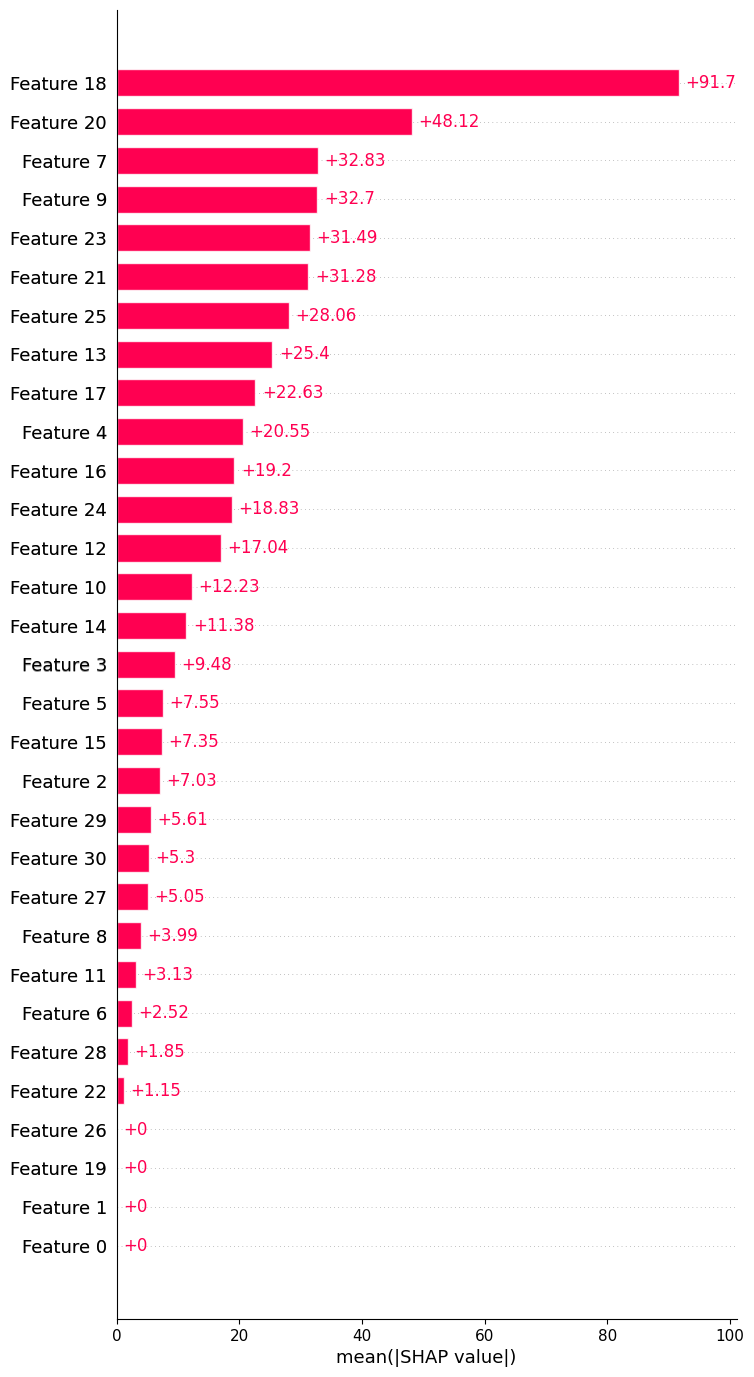

In [ ]:
## shap values
shap.plots.bar(shap_values,max_display = len(df[df.columns[df.columns != KPI_COL]].columns))

In [ ]:
vals= np.abs(shap_values.values).mean(axis = 0)

feature_importance = pd.DataFrame(list(zip(df[df.columns[df.columns != KPI_COL]].columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
18,DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0,91.699060
20,DIV_PKG_HDStreamingl21_0p0_0d0_12,48.115358
7,C_DIV_GETNOW_CONNl21_0p0_0d0_0,32.830401
9,C_DIV_GETNOW_PREMl21_0p0_0d0_06,32.702624
23,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,31.489826
21,DIV_PLANPAGE_CONNl21_0p0_0d0_0,31.283877
25,OC_PAGE_ESSl21_0p0_0d0_06,28.056737
13,C_PP_PKG_ESSl21_0p0_0d0_12,25.402586
17,DIV_GMOC_SHOP_ESSl21_0p0_0d0_0,22.630362
4,C_DIV_CONN_DATAl21_0p0_0d0_12,20.546381


In [ ]:
# rescale the shap values to result in a scale rleative to total r-squared

sum_feature_imp = feature_importance.feature_importance_vals.sum()
scale_factor = reg.score(X,y)

feature_importance['attribution'] = feature_importance.feature_importance_vals / (sum_feature_imp / scale_factor)
feature_importance

,col_name,feature_importance_vals,attribution
18,DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0,91.699060,0.140972
20,DIV_PKG_HDStreamingl21_0p0_0d0_12,48.115358,0.073970
7,C_DIV_GETNOW_CONNl21_0p0_0d0_0,32.830401,0.050471
9,C_DIV_GETNOW_PREMl21_0p0_0d0_06,32.702624,0.050275
23,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,31.489826,0.048411
21,DIV_PLANPAGE_CONNl21_0p0_0d0_0,31.283877,0.048094
25,OC_PAGE_ESSl21_0p0_0d0_06,28.056737,0.043133
13,C_PP_PKG_ESSl21_0p0_0d0_12,25.402586,0.039052
17,DIV_GMOC_SHOP_ESSl21_0p0_0d0_0,22.630362,0.034791
4,C_DIV_CONN_DATAl21_0p0_0d0_12,20.546381,0.031587


In [ ]:
round(feature_importance.attribution.sum(),5)

0.77397

## 4) Validate Linear Regression Model Assumptions

### 4.1) Generate model residuals

In [ ]:
residuals = Y_prediction - y

#Y_prediction
#y

###4.2) Linearity

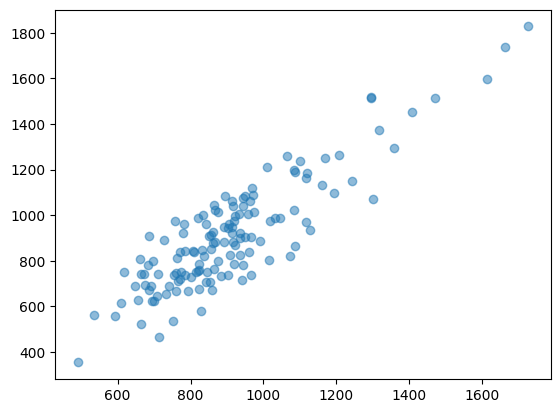

In [ ]:
'''
Visually inspect linearity between target variable (y1) and predictions
'''
plt.plot(Y_prediction,y,'o',alpha=0.5)
plt.show()

### 4.3) Normality of Errors

In [ ]:
'''
Visually inspect the residuals to confirm normality
'''

'\nVisually inspect the residuals to confirm normality\n'

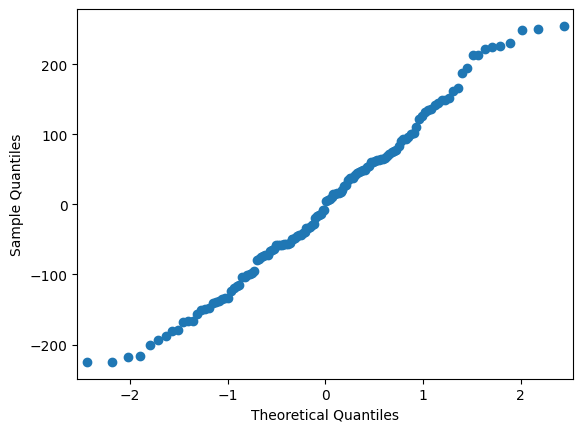

In [ ]:
fig = sm.qqplot(residuals)

<ipython-input-101-24786c19d6f5>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, label = '', shade = True)


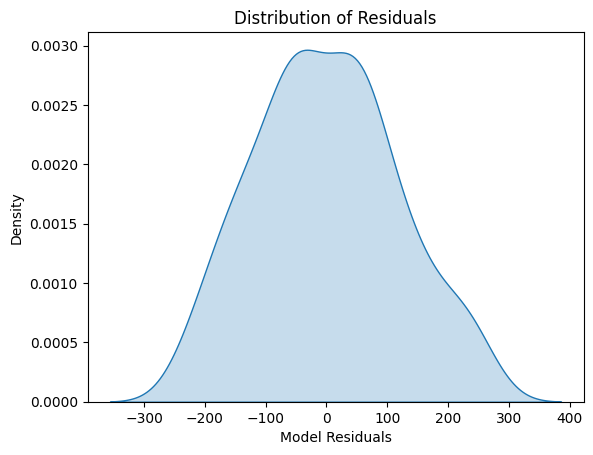

In [ ]:
sns.kdeplot(residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

###4.4) Homoscedasticity


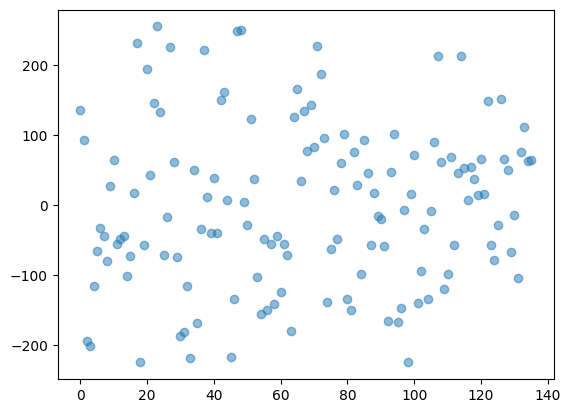

In [ ]:
'''
Visually inspect residuals to confirm constant variance
'''
plt.plot(residuals,'o',alpha=0.5)
plt.show()

###4.5) Residual Autocorrelation Check

In [ ]:
'''
The Durbin Watson test is a statistical test for detecting autocorrelation of the
model residuals
'''

dw = durbin_watson(residuals)
print('Durbin-Watson',dw)

Durbin-Watson 1.3905918290689876


In [ ]:
if dw < 1.5:
        print('Positive autocorrelation', '\n')
elif dw > 2.5:
        print('Negative autocorrelation', '\n')
else:
        print('Little to no autocorrelation', '\n')


Positive autocorrelation 



In [ ]:
#df.head()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'X' is your predictors DataFrame

# Assuming 'df' is your DataFrame with all the predictor variables
#X = df.drop(columns = [KPI_COL, date_col], axis=1)  # Assuming 'y1' is your target variable
X = df.drop(columns = [KPI_COL], axis=1)  # Assuming 'y1' is your target variable

# Add a constant to the model (if it's not already included)
X = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                               Feature       VIF
0                                const  1.111642
1    C_DIV_BUY_CONNECTEDl21_0p0_0d0_12  5.560340
2   C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12  3.085726
3       C_DIV_BUY_PREMIUMl21_0p0_0d0_0  4.597973
4           C_DIV_BUY_SSl21_0p0_0d0_12  2.834208
5        C_DIV_CONN_DATAl21_0p0_0d0_12  2.149931
6      C_DIV_CONN_REMOTEl21_0p0_0d0_12  2.626510
7         C_DIV_CONN_TRYl21_0p0_0d0_06  1.652309
8       C_DIV_GETNOW_CONNl21_0p0_0d0_0  5.426809
9       C_DIV_GETNOW_ESSl21_0p0_0d0_06  1.889364
10     C_DIV_GETNOW_PREMl21_0p0_0d0_06  3.945159
11       C_DIV_GETNOW_SSl21_0p0_0d0_12  8.271684
12   C_PP_PKG_APP_ACCESSl21_0p0_0d0_06  1.937382
13    C_PP_PKG_CONNECTEDl21_0p0_0d0_12  5.576811
14          C_PP_PKG_ESSl21_0p0_0d0_12  4.271246
15         C_PP_PKG_PREMl21_0p0_0d0_06  5.503147
16           C_PP_PKG_SCl21_0p0_0d0_06  1.546079
17           C_PP_PKG_SSl21_0p0_0d0_06  3.340952
18      DIV_GMOC_SHOP_ESSl21_0p0_0d0_0  8.442971
19   DIV_GMOC_SHOP_R

## 5) Export Final Results

In [ ]:
final_results_df = feature_importance[['col_name','attribution']]
final_results_df.to_csv('rba_final_output.csv', encoding = 'utf-8-sig')
files.download('rba_final_output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>